## **IMPORTS**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para fazer a PADRONIZAÇÃO
from sklearn.preprocessing import StandardScaler

# Biblioteca para fazer a NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler

# Bilioteca para separação de dados em treino e teste
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

# Biblioteca para calcular a acuracia do modelo
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score

import lime
import lime.lime_tabular

from imblearn.over_sampling import ADASYN
from collections import Counter

from scipy.stats import tukey_hsd
from scipy import stats

## **LEITURA DOS DADOS**

In [7]:
data = pd.read_csv('../Base de Dados/Dados_49_V.csv', na_values='?')

#data = pd.read_csv('../Base de Dados/Dados_10_V_FISHER.csv', na_values='?')

print(data.shape)
data.head()

(2185, 50)


,regiao,exploracao,criacao,n_ordenha,t_ordenha,inseminacao_2cat,raca_bovinos,total_animais_prop,ov_capr,eq,...,como_resfr,leite_granel,queijo_mant,final_queijo_mant,consome_leite_cru,assist_vet,tipo_assist,aguadas_bebedouro,classificacao_propriedade,resul_prop
0,6,2,3,1,1,0,2,15,0,0,...,-1,0,0,-1,1,0,-1,0,1,0
1,6,2,2,2,3,0,2,142,0,1,...,1,1,0,-1,1,0,-1,0,1,0
2,6,2,2,2,2,0,2,40,0,1,...,-1,0,0,-1,1,0,-1,0,1,0
3,6,2,2,2,1,0,2,68,0,0,...,-1,1,0,-1,1,0,-1,0,1,0
4,6,2,2,1,1,0,2,38,0,0,...,-1,0,1,2,1,0,-1,0,1,0


In [8]:
# Gerando um DataFrame das variáveis preditoras originais SEM a variável TARGET
VAR_PREDITORAS_ORIG = data.drop('resul_prop', axis = 1)

# Gerando um DataFrame somente da variavel TARGET
VAR_TARGET = data['resul_prop']

## **NORMALIZAÇÃO**

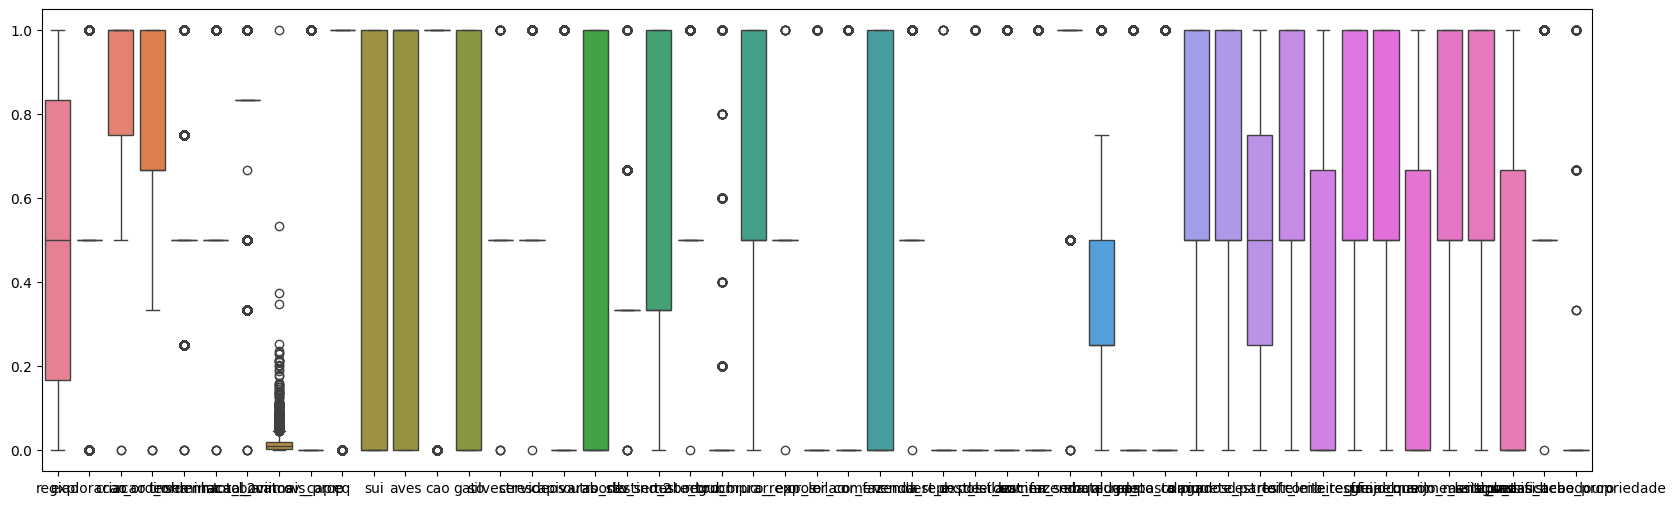

In [9]:
# Criando um objeto para NORMALIZAR os dados
obj_normalizacao = MinMaxScaler().fit(VAR_PREDITORAS_ORIG)

# Aplicando a NORMALIZAÇÃO
VAR_PREDITORAS_NORM = obj_normalizacao.transform(VAR_PREDITORAS_ORIG)

# Transformando para DataFrame e nomeando as colunas
VAR_PREDITORAS_NORM = pd.DataFrame(VAR_PREDITORAS_NORM)

VAR_PREDITORAS_NORM.columns = data.drop('resul_prop', axis = 1).columns

VAR_PREDITORAS_NORM

plt.figure(figsize=(20,6))
ax = sns.boxplot(data=VAR_PREDITORAS_NORM)

## **AGRUPAMENTO**

In [10]:
DATA_NORM = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET)
DATA_NORM_NEG = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 0').reset_index(drop=True)
DATA_NORM_POS = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 1').reset_index(drop=True)

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(DATA_NORM_NEG.drop('resul_prop', axis = 1))
#print(kmeans.labels_)

#print(pd.DataFrame(kmeans.labels_))
DATA_NORM_NEG = DATA_NORM_NEG.assign(group=pd.DataFrame(kmeans.labels_))

DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG.query('group == 0')
#print(DATA_NORM_NEG_GROUP0.shape)

DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG.query('group == 1')
#print(DATA_NORM_NEG_GROUP1.shape)

DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG.query('group == 2')
#print(DATA_NORM_NEG_GROUP2.shape)

DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG.query('group == 3')
#print(DATA_NORM_NEG_GROUP3.shape)

DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)

## **RNA + ADASYN**

In [11]:
accuracy_adasyn = []
neg_prec_adasyn = []
neg_recall_adasyn = []
neg_fscore_adasyn = []
pos_prec_adasyn = []
pos_recall_adasyn = []
pos_fscore_adasyn = []
auc_adasyn = []

num_am_grupo_neg = 60
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)


    #-------------------------- ADASYN -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS_ADASYN = DATA_NORM_POS.head(num_am_grupo_pos)

    CLASSE_NEG_ADASYN = DATA_NORM_NEG.drop('group', axis = 1)

    X_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN.drop('resul_prop', axis = 1),
        CLASSE_POS_ADASYN.drop('resul_prop', axis = 1)]).reset_index(drop=True)

    Y_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN['resul_prop'],
        CLASSE_POS_ADASYN['resul_prop']]).reset_index(drop=True)

    ada = ADASYN(sampling_strategy=0.12, n_neighbors=6)

    X_RESAMPLING, Y_RESAMPLING = ada.fit_resample(X_ADASYN_ORIGINAL, Y_ADASYN_ORIGINAL)


    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    CLASSE_POS = X_RESAMPLING.assign(resul_prop=Y_RESAMPLING).query('resul_prop == 1').reset_index(drop=True)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO RNA -------------------------------
    rna = MLPClassifier(max_iter=1000000, hidden_layer_sizes = (30)).fit(X_TRAIN.values, Y_TRAIN.values)

    #-------------------------- TESTE RNA -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)
    
    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = rna.predict(X_TEST)

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_adasyn.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_adasyn.append(report['Negativo']['precision'])
    neg_recall_adasyn.append(report['Negativo']['recall'])
    neg_fscore_adasyn.append(report['Negativo']['f1-score'])

    pos_prec_adasyn.append(report['Positivo']['precision'])
    pos_recall_adasyn.append(report['Positivo']['recall'])
    pos_fscore_adasyn.append(report['Positivo']['f1-score'])

    auc_adasyn.append(roc_auc_score(Y_TEST, rna.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppDa

FIM
